In [1]:
import keras_genomics
from keras_genomics.layers.convolutional import RevCompConv1D
import keras
import keras.layers as kl
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
from seqdataloader.batchproducers import coordbased
from seqdataloader.batchproducers.coordbased import coordstovals
from seqdataloader.batchproducers.coordbased import coordbatchproducers
from seqdataloader.batchproducers.coordbased import coordbatchtransformers
from keras.models import load_model
from keras.utils import CustomObjectScope
from deeplift.dinuc_shuffle import dinuc_shuffle
import json
import os
import gzip
from math import log
from matplotlib import pyplot as plt
from scipy.stats import spearmanr, pearsonr, gaussian_kde
%matplotlib inline

Using TensorFlow backend.
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/users/amr1/mi

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3"
def multinomial_nll(true_counts, logits):
    """Compute the multinomial negative log-likelihood
    Args:
      true_counts: observed count values
      logits: predicted logit values
    """
    counts_per_example = tf.reduce_sum(true_counts, axis=-1)
    dist = tfp.distributions.Multinomial(total_count=counts_per_example,
                                         logits=logits)
    return (-tf.reduce_sum(dist.log_prob(true_counts)) / 
            tf.to_float(tf.shape(true_counts)[0]))

#from https://github.com/kundajelab/basepair/blob/cda0875571066343cdf90aed031f7c51714d991a/basepair/losses.py#L87
class MultichannelMultinomialNLL(object):
    def __init__(self, n):
        self.__name__ = "MultichannelMultinomialNLL"
        self.n = n

    def __call__(self, true_counts, logits):
        for i in range(self.n):
            loss = multinomial_nll(true_counts[..., i], logits[..., i])
            if i == 0:
                total = loss
            else:
                total += loss
        return total

    def get_config(self):
        return {"n": self.n}

In [3]:
with CustomObjectScope({'MultichannelMultinomialNLL': MultichannelMultinomialNLL,'RevCompConv1D': RevCompConv1D}):
    model = load_model("data/models/pho4_pbexo_model.h5")







Instructions for updating:
Use `tf.cast` instead.


In [4]:
barbaric_seqToActiv = {}
raj_seqToExposed = {}
raj_seqToNucleosomal = {}

In [5]:
!head data/experimental/Pho4_barbaric_data.csv

name,sequence,activity
WT,ACAAGGATCCGAAAGTTGTATTCAACAAGAATGCGCAAATATGTCAACGTATTTGGAAGTCATCTTATGTGCGCTGCTTTAATGTTTTCTCATGTAAGCGGACGTCGTCTATAAACTTCAAACGAAGGTAAAAGGTTCATAGCGCTTTTTCTTTGTCTGCACAAAGAAATATATATTAAATTAGCACGTTTTCGCATAGAACGCAACTGCACAATGCCAAAAAAAGTAAAAGTGATTAAAAGAGTTAATTGAATAGGCAATCTCTAAATGAATCGATACAACCTTGGCACTCACACGTGGGACTAGCACAGACTAAATTTATGATTCTGGTCCCTGTTTTCGAAGAGATCGCACATGCCAAATTATCAAATTGGTCACCTTACTTGGCAAGGCATATACCCATTTGGGATAAGGGTAAACATCTTTGAATTGTCGAAATGAAACGTATATAAGCGCTGATGTTTTGCTAAGTCGAGGTTAGTATGGCTTCATCTCTCATGAGAATAAGAACAACAACAAATAGAGCAAGCAAATTCGAGATTACCA,1.0
UASp1_mut,ACAAGGATCCGAAAGTTGTATTCAACAAGAATGCGCAAATATGTCAACGTATTTGGAAGTCATCTTATGTGCGCTGCTTTAATGTTTTCTCATGTAAGCGGACGTCGTCTATAAACTTCAAACGAAGGTAAAAGGTTCATAGCGCTTTTTCTTTGTCTGCACAAAGAAATATATATTAAATTAGTCTAGATTCGCATAGAACGCAACTGCACAATGCCAAAAAAAGTAAAAGTGATTAAAAGAGTTAATTGAATAGGCAATCTCTAAATGAATCGATACAACCTTGGCACTCACACGTGGGACTAGCACAGACTAAATTTATGATTCTGGTCCCTGTTTTCGAAGAGATCGCACATGCCAAATTATCAAATTGGTCACCTTACTTGGCAAGGCATATACCCATTTGGGATAAG

In [6]:
with open("data/experimental/Pho4_barbaric_data.csv", encoding='utf-8-sig') as inp:
    firstLine = True
    for line in inp:
        if firstLine:
            firstLine = False
            continue
        barbaric_seqToActiv[line.strip().split(',')[1]] = float(line.strip().split(',')[-1])

In [7]:
!head data/experimental/Pho4_rajkumar.csv

﻿Promoter,Exposed site ,Nucleosomal site ,Pho4 Exposed site ddG ,Pho4 Nucleosomal site ddG,Promoter sequence (5' to 3')
Wild-type (WT),TAGCACGTTTTC,TCACACGTGGGA,2.86473,0.79545,TTTTACACATCGGACTGATAAGTTACTACTGCACATTGGCATTAGCTAGGAGGGCATCCAAGTAATAATTGCGAGAAACGTGACCCAACTTTGTTGTAGGTCCGCTCCTTCTAATAATCGCTTGTATCTCTACATATGTTCTATTTACTGACCGAAAGTAGCTCGCTACAATAATAATGTTGACCTGATGTCAGTCCCCACGCTAATAGCGGCGTGTCGCACGCTCTCTTTACAGGACGCCGGAGACCGGCATTACAAGGATCCGAAAGTTGTATTCAACAAGAATGCGCAAATATGTCAACGTATTTGGAAGTCATCTTATGTGCGCTGCTTTAATGTTTTCTCATGTAAGCGGACGTCGTCTATAAACTTCAAACGAAGGTAAAAGGTTCATAGCGCTTTTTCTTTGTCTGCACAAAGAAATATATATTAAATTAGCACGTTTTCGCATAGAACGCAACTGCACAATGCCAAAAAAAGTAAAAGTGATTAAAAGAGTTAATTGAATAGGCAATCTCTAAATGAATCGATACAACCTTGGCACTCACACGTGGGACTAGCACAGACTAAATTTATGATTCTGGTCCCTGTTTTCGAAGAGATCGCACATGCCAAATTATCAAATTGGTCACCTTACTTGGCAAGGCATATACCCATTTGGGATAAGGGTAAACATCTTTGAATTGTCGAAATGAAACGTATATAAGCGCTGATGTTTTGCTAAGTCGAGGTTAGTATGGCTTCATCTCTCATGAGAATAAGAACAACAACAAATAGAGCAAGCAAATTCGAGATTACCA
A1,Wild-type ,TCATTTGT

In [8]:
with open("data/experimental/Pho4_rajkumar.csv", encoding='utf-8-sig') as inp:
    firstLine = True
    for line in inp:
        if firstLine:
            firstLine = False
            continue
        raj_seqToExposed[line.strip().split(',')[-1]] = float(line.strip().split(',')[-3])
        raj_seqToNucleosomal[line.strip().split(',')[-1]] = float(line.strip().split(',')[-2])

In [9]:
fastapath = "data/genome/saccer/sacCer3.genome.fa"
GenomeDict={}
sequence=''
inputdatafile = open(fastapath)
for line in inputdatafile:
    if line[0]=='>':
        if sequence != '':
            GenomeDict[chrm] = ''.join(sequence)
        chrm = line.strip().split('>')[1]
        sequence=[]
        Keep=False
        continue
    else:
        sequence.append(line.strip())
GenomeDict[chrm] = ''.join(sequence)

seq_len = 546
out_pred_len = 200
test_chrms = ["chrX", "chrXI"]
seq_peaks = []
with open("data/pho4_pbexo/pho4.pbexo.bed") as inp:
    for line in inp:
        chrm = line.strip().split('\t')[0]
        if chrm not in test_chrms:
            continue
        pStart = int(line.strip().split('\t')[1])
        summit = pStart + 1
        start = int(summit - (seq_len/2))
        end = int(summit + (seq_len/2))
        seq_peaks.append(GenomeDict[chrm][start:end].upper())

ltrdict = {
           'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1],
           'n':[0,0,0,0],'A':[1,0,0,0],'C':[0,1,0,0],'G':[0,0,1,0],
           'T':[0,0,0,1],'N':[0,0,0,0],'Y':[0,0.5,0,0.5],
           'S':[0,0.5,0.5,0], 'M':[0.5,0.5,0,0], 'W':[0.5,0,0,0.5],
           'R':[0.5,0,0.5,0]}
def getOneHot(ISM_sequences):
  # takes in list of sequences
    one_hot_seqs = []
    for seq in ISM_sequences:
        one_hot = []
        for i in range(len(seq)):
            one_hot.append(ltrdict[seq[i:i+1]])
        one_hot_seqs.append(one_hot)
    return np.array(one_hot_seqs)

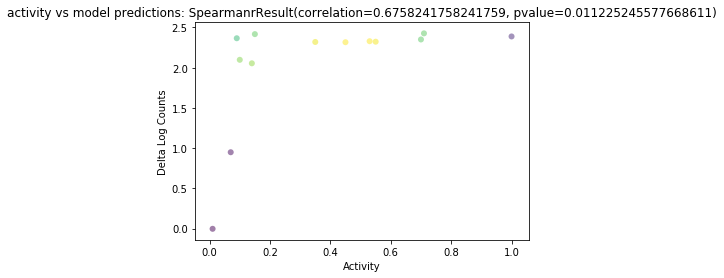

In [18]:
from deeplift.dinuc_shuffle import dinuc_shuffle
num_samples = 100
indices = np.random.choice(len(seq_peaks), num_samples, replace=False)

xvals = []
yvals = []
for test_seq in barbaric_seqToActiv:
    pre_seqs = []
    post_seqs = []
    for idx in indices:
        pre_seq = dinuc_shuffle(seq_peaks[idx])
        pre_seqs.append(pre_seq)
        post_seqs.append(test_seq)
    pre = model.predict([getOneHot(pre_seqs), np.zeros((num_samples,)), np.zeros((num_samples,out_pred_len,2))])
    post = model.predict([getOneHot(post_seqs), np.zeros((num_samples,)), np.zeros((num_samples,out_pred_len,2))])
    xvals.append(barbaric_seqToActiv[test_seq])
    yvals.append(np.mean(post[0]-pre[0]))

xy = np.vstack([xvals,yvals])
z = gaussian_kde(xy)(xy)
smallFont = {'size' : 10}
plt.rc('font', **smallFont)
fig, ax = plt.subplots()
ax.scatter(xvals, yvals, c=z, edgecolor='', alpha=0.5)
plt.xlabel("Activity")
plt.ylabel("Delta Log Counts")
plt.title("activity vs model predictions: "+str(spearmanr(xvals, yvals)))
plt.show()

In [19]:
xvals_exposed = []
xvals_nucleosomal = []
yvals = []
yvals_dict = {}
for whole_seq in raj_seqToExposed:
    test_seq = whole_seq[-seq_len:]
    pre_seqs = []
    post_seqs = []
    for idx in indices:
        pre_seq = dinuc_shuffle(seq_peaks[idx])
        pre_seqs.append(pre_seq)
        post_seqs.append(test_seq)
    pre = model.predict([getOneHot(pre_seqs), np.zeros((num_samples,)), np.zeros((num_samples,out_pred_len,2))])
    post = model.predict([getOneHot(post_seqs), np.zeros((num_samples,)), np.zeros((num_samples,out_pred_len,2))])
    xvals_exposed.append(raj_seqToExposed[whole_seq])
    xvals_nucleosomal.append(raj_seqToNucleosomal[whole_seq])
    yvals_dict[whole_seq] = np.mean(post[0]-pre[0])
    yvals.append(yvals_dict[whole_seq])

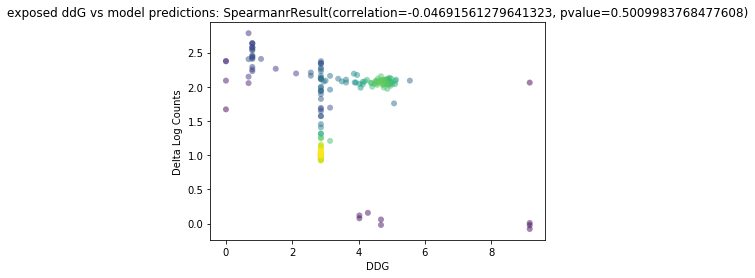

In [20]:
xy = np.vstack([xvals_exposed,yvals])
z = gaussian_kde(xy)(xy)
smallFont = {'size' : 10}
plt.rc('font', **smallFont)
fig, ax = plt.subplots()
ax.scatter(xvals_exposed, yvals, c=z, edgecolor='', alpha=0.5)
plt.xlabel("DDG")
plt.ylabel("Delta Log Counts")
plt.title("exposed ddG vs model predictions: "+str(spearmanr(xvals_exposed, yvals)))
plt.show()

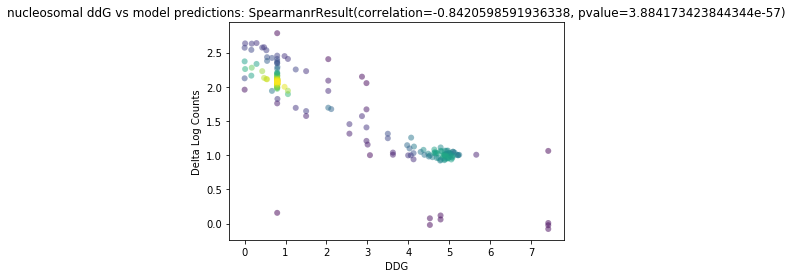

In [21]:
xy = np.vstack([xvals_nucleosomal,yvals])
z = gaussian_kde(xy)(xy)
smallFont = {'size' : 10}
plt.rc('font', **smallFont)
fig, ax = plt.subplots()
ax.scatter(xvals_nucleosomal, yvals, c=z, edgecolor='', alpha=0.5)
plt.xlabel("DDG")
plt.ylabel("Delta Log Counts")
plt.title("nucleosomal ddG vs model predictions: "+str(spearmanr(xvals_nucleosomal, yvals)))
plt.show()

In [22]:
f = open('data/preds/pho4_rajkumar_preds.csv','w')
f.write("sequence, observed, predicted\n")
for key in yvals_dict:
    f.write(key+','+str(raj_seqToNucleosomal[key])+','+str(yvals_dict[key])+'\n')
f.close()

In [23]:
!head data/preds/pho4_rajkumar_preds.csv

sequence, observed, predicted
TTTTACACATCGGACTGATAAGTTACTACTGCACATTGGCATTAGCTAGGAGGGCATCCAAGTAATAATTGCGAGAAACGTGACCCAACTTTGTTGTAGGTCCGCTCCTTCTAATAATCGCTTGTATCTCTACATATGTTCTATTTACTGACCGAAAGTAGCTCGCTACAATAATAATGTTGACCTGATGTCAGTCCCCACGCTAATAGCGGCGTGTCGCACGCTCTCTTTACAGGACGCCGGAGACCGGCATTACAAGGATCCGAAAGTTGTATTCAACAAGAATGCGCAAATATGTCAACGTATTTGGAAGTCATCTTATGTGCGCTGCTTTAATGTTTTCTCATGTAAGCGGACGTCGTCTATAAACTTCAAACGAAGGTAAAAGGTTCATAGCGCTTTTTCTTTGTCTGCACAAAGAAATATATATTAAATTAGCACGTTTTCGCATAGAACGCAACTGCACAATGCCAAAAAAAGTAAAAGTGATTAAAAGAGTTAATTGAATAGGCAATCTCTAAATGAATCGATACAACCTTGGCACTCACACGTGGGACTAGCACAGACTAAATTTATGATTCTGGTCCCTGTTTTCGAAGAGATCGCACATGCCAAATTATCAAATTGGTCACCTTACTTGGCAAGGCATATACCCATTTGGGATAAGGGTAAACATCTTTGAATTGTCGAAATGAAACGTATATAAGCGCTGATGTTTTGCTAAGTCGAGGTTAGTATGGCTTCATCTCTCATGAGAATAAGAACAACAACAAATAGAGCAAGCAAATTCGAGATTACCA,0.79545,2.3479311
TTTTACACATCGGACTGATAAGTTACTACTGCACATTGGCATTAGCTAGGAGGGCATCCAAGTAATAATTGCGAGAAACGTGACCCAACTTTGTTGTAGGTCCGCTCCTTCTAATAATCGCTTGTATCTCTACATATGTTCTATTTACTGA